<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [18]:
import biom
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
data_dir = '../data/amplicon_comparison'
inf_z = az.from_netcdf(f'{data_dir}/differentials_z.nc')
inf_d = az.from_netcdf(f'{data_dir}/differentials_d.nc')
inf_b = az.from_netcdf(f'{data_dir}/differentials_b.nc')

z_diff = inf_z['posterior']['diff'].to_dataframe()
d_diff = inf_d['posterior']['diff'].to_dataframe()
b_diff = inf_b['posterior']['diff'].to_dataframe()

FileNotFoundError: [Errno 2] No such file or directory: b'../data/amplicon_comparison/differentials_d.nc'

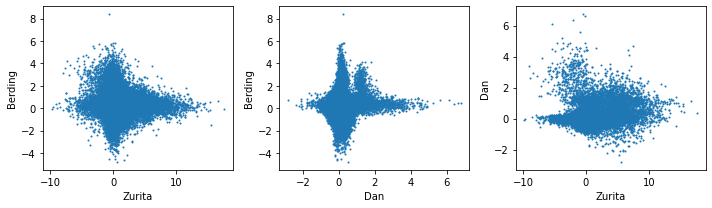

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].scatter(-z_diff.values, -b_diff.values, s=1)
ax[1].scatter(-d_diff.values, -b_diff.values, s=1)
ax[2].scatter(-z_diff.values, -d_diff.values, s=1)
ax[0].set_xlabel('Zurita')
ax[0].set_ylabel('Berding')
ax[1].set_xlabel('Dan')
ax[1].set_ylabel('Berding')
ax[2].set_xlabel('Zurita')
ax[2].set_ylabel('Dan')
plt.tight_layout()

In [21]:
z_mean = z_diff.reset_index().groupby('features').mean()['diff']
d_mean = d_diff.reset_index().groupby('features').mean()['diff']
b_mean = b_diff.reset_index().groupby('features').mean()['diff']

amp_means = pd.DataFrame({'zurita': z_mean,
                          'dan': d_mean,
                          'berding': b_mean}).dropna()

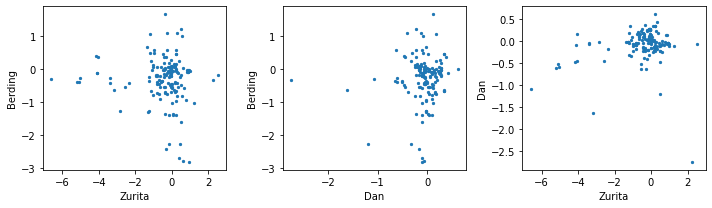

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].scatter(z_mean.values, b_mean.values, s=5)
ax[1].scatter(d_mean.values, b_mean.values, s=5)
ax[2].scatter(z_mean.values, d_mean.values, s=5)
ax[0].set_xlabel('Zurita')
ax[0].set_ylabel('Berding')
ax[1].set_xlabel('Dan')
ax[1].set_ylabel('Berding')
ax[2].set_xlabel('Zurita')
ax[2].set_ylabel('Dan')
plt.tight_layout()

Double check orientation

In [23]:
!ls ../data/amplicon_comparison/sample_metadata.txt

../data/amplicon_comparison/sample_metadata.txt


% accuracy 0.8489208633093526


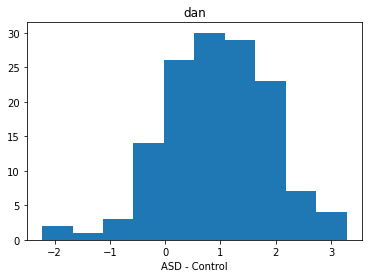

% accuracy 0.9545454545454546


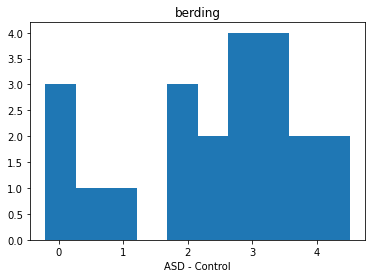

% accuracy 0.8636363636363636


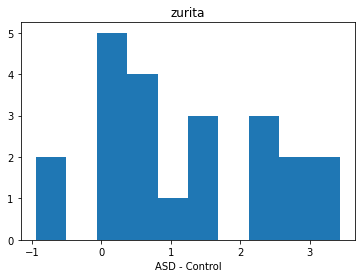

In [24]:
dirpath = '../data/amplicon_comparison'
md_ = pd.read_table(f'{dirpath}/sample_metadata.txt', index_col=0)

for fname in ['dan', 'berding', 'zurita']:
    table = biom.load_table(f'{dirpath}/{fname}.biom').to_dataframe().T
    md = md_.loc[table.index]

    pairs = []
    d_mean = amp_means[fname].sort_values()
    d_mean = d_mean.sort_values()
    for n, pair in md.groupby('Match_IDs'):
        p = pair.sort_values('Status')
        asd, con = p.index[0], p.index[1]
        top = d_mean.tail(20).index
        bot = d_mean.head(20).index
        asd_lr = np.log(table.loc[asd, top] + 0.5).mean() - np.log(table.loc[asd, bot] + 0.5).mean()
        con_lr = np.log(table.loc[con, top] + 0.5).mean() - np.log(table.loc[con, bot] + 0.5).mean()
        lr = asd_lr - con_lr
        pairs.append(lr)
    _ = plt.hist(pairs)
    plt.xlabel('ASD - Control')
    plt.title(fname)
    print('% accuracy', np.mean(np.array(pairs) > 0))
    plt.show()

Look into taxonomy

In [25]:
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxonomy, taxid, left_index=True, right_on='GOTU')
lookup = mapping[['GOTU', 'genome']].set_index('genome')

In [26]:
submapping = mapping.set_index('genome').loc[d_mean.index]
submapping['log_fold_change'] = d_mean
pd.set_option('display.max_rows', 200)

In [27]:
submapping.to_csv('amplicon_mapping.csv')

In [36]:
submapping.sort_values('log_fold_change').tail()

,kingdom,phylum,class,order,family,genus,species,GOTU,log_fold_change
genome,,,,,,,,,
239935,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,Akkermansia muciniphila,G000723745,1.690323
742818,Bacteria,Actinobacteria,Coriobacteriia,Eggerthellales,Eggerthellaceae,Slackia,Slackia piriformis,G000296445,1.865328
1203554,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Sutterella,Sutterella wadsworthensis,G000411515,2.008032
518636,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,[Clostridium] asparagiforme,G000158075,2.581436
610130,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,[Clostridium] saccharolyticum,G000144625,2.975976


In [37]:
inf_z = az.from_netcdf(f'{data_dir}/differentials_z.nc')
z_diff = inf_z['posterior']['diff'].to_dataframe()
z_mean = z_diff.reset_index().groupby('features').mean()['diff']
inf_z

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [38]:
submapping = mapping.set_index('genome').loc[z_mean.index]
submapping['log_fold_change'] = z_mean

In [39]:
submapping.sort_values('log_fold_chan').tail(50)

,kingdom,phylum,class,order,family,genus,species,GOTU,log_fold_change
genome,,,,,,,,,
515619,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,[Eubacterium] rectale,G000020605,-0.133632
515620,Bacteria,Firmicutes,Clostridia,Clostridiales,Eubacteriaceae,Eubacterium,[Eubacterium] eligens,G000146185,-0.598800
518634,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium breve,G001025175,-0.632803
518635,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium angulatum,G001025155,-0.531148
518636,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoclostridium,[Clostridium] asparagiforme,G000158075,2.581436
521003,Bacteria,Actinobacteria,Coriobacteriia,Coriobacteriales,Coriobacteriaceae,Collinsella,Collinsella intestinalis,G000156175,-3.183447
536231,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia intestinalis,G000156535,-0.055089
537007,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,Blautia hansenii,G000156675,0.313364
537011,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella copri,G000157935,0.577955
